# Olist - RFM Analysis

Customer Segmentation 

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Table of Content</h3>

1. [Data Quality](#Data-Quality)
2. [Dropping Nulls](#Dropping-Nulls)
3. [Merge Tables](#Merge-Tables)
    1. [Exploring Order Payments Table](#Exploring-Order-Payments-Table)
    2. [Merge Table V2](#Merge-Table-V2)
4. [Convert Time Column to pd.datetime](#Convert-Time-Column-to-pd.datetime)
5. [Creating RFM Variables](#Creating-RFM-Variables)
6. [Merging R, F, M](#Merging-R,-F,-M)
7. [Checking Outliers](#Checking-Outliers)
8. [Creating RFM Segments](#Creating-RFM-Segments)
9. [Power BI Exports](#Power-BI-Exports)

<a name='Data-Quality'></a>
# Data Quality

[Go to TOC](#top)

**Notes:**

`order_id` in orders table is unique

`order_status` in orders table is SCD type 1

In [1]:
# importing necessary libaries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading data 
customers = pd.read_csv("data\customers.csv")
orders = pd.read_csv("data\orders.csv")
order_payments = pd.read_csv("data\order_payments.csv")

In [3]:
# Collections for each dataset
datasets = [customers, orders, order_payments]
            
names = ['customers', 'orders', 'order_reviews']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_rows'] = [df.isnull().any(axis=1).sum() for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_rows,null_amount,qty_null_columns,null_columns
0,customers,99441,5,0,0,0,
1,orders,99441,8,2980,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
2,order_reviews,103886,5,0,0,0,


<a name='Dropping-Nulls'></a>
# Dropping Nulls
 
[Go to TOC](#top)

In [4]:
for i in datasets:
    i.dropna(inplace=True)

for i in datasets:
    i.drop(i[i.duplicated()].index, axis=0, inplace=True)

In [5]:
# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_rows'] = [df.isnull().any(axis=1).sum() for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_rows,null_amount,qty_null_columns,null_columns
0,customers,99441,5,0,0,0,
1,orders,96461,8,0,0,0,
2,order_reviews,103886,5,0,0,0,


<a name='Merge Tables '></a>
# Merge Tables 
[Go to TOC](#top)

In [6]:
merged_df = pd.merge(customers, orders, on="customer_id", how="inner")
merged_df.shape

(96461, 12)

In [7]:
merged_df= merged_df.merge(order_payments, on="order_id", how="inner")
merged_df.shape

(100739, 16)

We see that after merging with order_payments, rows went from 94,461 to 100,739.

If you're getting more rows after a left join, it typically means that there are multiple matching rows in the right table for at least some rows in the left table. This is a common occurrence when there are one-to-many relationships between the tables.

![alt text](<left join.PNG>)

<a name='Exploring-Order-Payments-Table'></a>
## Exploring Order Payments Table
[Go to TOC](#top)

In [8]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [9]:
order_payments.shape

(103886, 5)

In [10]:
order_payments["order_id"].nunique()

99440

**Conclusion:** order_payments has 103,886 rows but 99,400 unique order_ids because of payment_sequential. We need to create a new table with order_id is unique and payment value is full aggregated per order

In [11]:
agg_order_payments = order_payments.groupby("order_id")["payment_value"].sum().reset_index()
agg_order_payments

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,343.40
99436,fffcd46ef2263f404302a634eb57f7eb,386.53
99437,fffce4705a9662cd70adb13d4a31832d,116.85
99438,fffe18544ffabc95dfada21779c9644f,64.71


<a name='Merge-Table-V2'></a>
## Merge Table V2
[Go to TOC](#top)

In [12]:
merged_df = pd.merge(customers, orders, on="customer_id", how="inner")
merged_df.shape

(96461, 12)

In [13]:
merged_df= merged_df.merge(agg_order_payments, on="order_id", how="left")
merged_df.shape

(96461, 13)

We can see that the merge was successful without gaining any rows.

In [14]:
merged_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25


In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96461 entries, 0 to 96460
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    96461 non-null  object 
 1   customer_unique_id             96461 non-null  object 
 2   customer_zip_code_prefix       96461 non-null  int64  
 3   customer_city                  96461 non-null  object 
 4   customer_state                 96461 non-null  object 
 5   order_id                       96461 non-null  object 
 6   order_status                   96461 non-null  object 
 7   order_purchase_timestamp       96461 non-null  object 
 8   order_approved_at              96461 non-null  object 
 9   order_delivered_carrier_date   96461 non-null  object 
 10  order_delivered_customer_date  96461 non-null  object 
 11  order_estimated_delivery_date  96461 non-null  object 
 12  payment_value                  96460 non-null 

`order_purchase_timestamp` is currently a object data type. We need to change it to a datatime data type. 

<a name='Convert-Time-Column-to-pd.datetime'></a>
# Convert Time Column to pd.datetime
[Go to TOC](#top)

In [16]:
merged_df["order_purchase_timestamp"] = pd.to_datetime(merged_df["order_purchase_timestamp"])

In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96461 entries, 0 to 96460
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    96461 non-null  object        
 1   customer_unique_id             96461 non-null  object        
 2   customer_zip_code_prefix       96461 non-null  int64         
 3   customer_city                  96461 non-null  object        
 4   customer_state                 96461 non-null  object        
 5   order_id                       96461 non-null  object        
 6   order_status                   96461 non-null  object        
 7   order_purchase_timestamp       96461 non-null  datetime64[ns]
 8   order_approved_at              96461 non-null  object        
 9   order_delivered_carrier_date   96461 non-null  object        
 10  order_delivered_customer_date  96461 non-null  object        
 11  order_estimated

In [18]:
# PowerBI Export 
agg_cust_payment = merged_df.groupby("customer_unique_id")["payment_value"].sum().reset_index()
#agg_cust_payment.to_csv("agg_cust_payment.csv", index=False)

In [19]:
agg_cust_payment[agg_cust_payment["customer_unique_id"] == "005226be8d5b972d0f72b4e8a79f322b"]

,customer_unique_id,payment_value
130,005226be8d5b972d0f72b4e8a79f322b,1600.51


We find the c id in R, F, M df

In [20]:
agg_cust_payment.shape

(93342, 2)

In [21]:
# no_outlier_agg_cust_payment = agg_cust_payment.merge(RFM_df, on="customer_unique_id", how="inner")
# no_outlier_agg_cust_payment = no_outlier_agg_cust_payment[["customer_unique_id", "payment_value"]]
# no_outlier_agg_cust_payment.shape

In [22]:
# no_outlier_agg_cust_payment.to_csv("agg_cust_payment.csv", index=False)

In [23]:
#RFM_df2[RFM_df2["customer_unique_id"] == "005226be8d5b972d0f72b4e8a79f322b"]

In [24]:
#RFM_df[RFM_df["customer_unique_id"] == "005226be8d5b972d0f72b4e8a79f322b"]

In [25]:
#RFM_df2.head()

# Creating RFM Variables <a name='Creating-RFM-Variables'></a>
[Go to TOC](#top)

For analysis, Let's determine current date (2 days after the last date):

In [26]:
present_day = merged_df['order_purchase_timestamp'].max() + dt.timedelta(days=2)
present_day

Timestamp('2018-08-31 15:00:37')

In [27]:
print("Latest date in dataset: ", merged_df['order_purchase_timestamp'].max())

Latest date in dataset:  2018-08-29 15:00:37


Latest date in dataset:  2018-08-29 14:18:28

Let's define "Recency", "Frequency", "Monetary" values:

In [28]:
recency_df= pd.DataFrame(merged_df.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max())
recency_df

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
...,...,...
93337,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36
93338,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56
93339,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16
93340,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41


In [29]:
recency_df['Recency']= recency_df['order_purchase_timestamp'].apply(lambda x: (present_day - x).days)
recency_df

,customer_unique_id,order_purchase_timestamp,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,116
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,538
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,322
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,289
...,...,...,...
93337,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,448
93338,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,263
93339,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,569
93340,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,120


In [30]:
frequency_df = pd.DataFrame(merged_df.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index())
frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)
frequency_df

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93337,fffcf5a5ff07b0908bd4e2dbc735a684,1
93338,fffea47cd6d3cc0a88bd621562a9d061,1
93339,ffff371b4d645b6ecea244b27531430a,1
93340,ffff5962728ec6157033ef9805bacc48,1


In [31]:
monetary_df = merged_df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_unique_id', 'Monetary']
monetary_df.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


# Merging R, F, M <a name='Merging-R,-F,-M'></a>
[Go to TOC](#top)

In [32]:
RF_df = recency_df.merge(frequency_df, on='customer_unique_id')
RFM_df = RF_df.merge(monetary_df, on='customer_unique_id').drop(columns='order_purchase_timestamp')
RFM_df.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
2,0000f46a3911fa3c0805444483337064,538,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89


In [33]:
RFM_df.shape

(93342, 4)

In [34]:
RFM_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,93342.0,238.927632,152.584210,2.0,115.00,220.00,347.000,715.00
Frequency,93342.0,1.033415,0.209091,1.0,1.00,1.00,1.000,15.00
Monetary,93342.0,165.195548,226.329058,0.0,63.05,107.78,182.535,13664.08


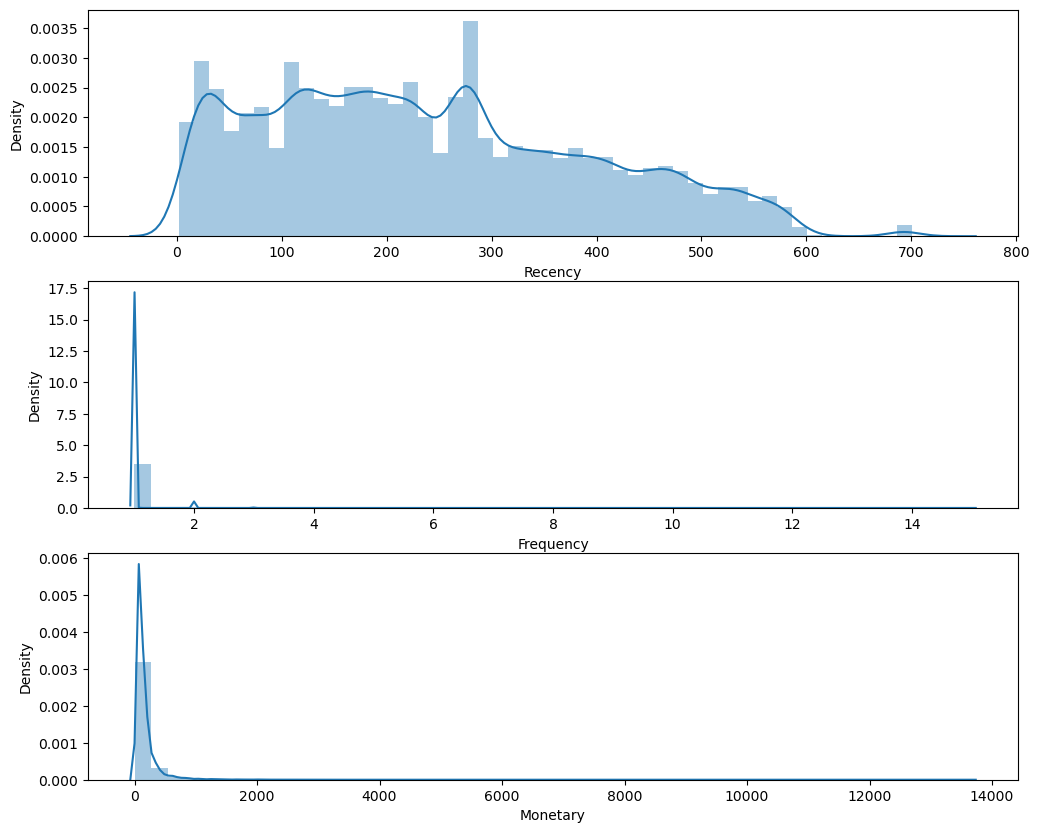

In [35]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1); sns.distplot(RFM_df['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_df['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_df['Monetary'])
plt.show()

In [36]:
RFM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93342 entries, 0 to 93341
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93342 non-null  object 
 1   Recency             93342 non-null  int64  
 2   Frequency           93342 non-null  int64  
 3   Monetary            93342 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


<a name='Checking-Outliers'></a>
# Checking Outliers
[Go to TOC](#top)

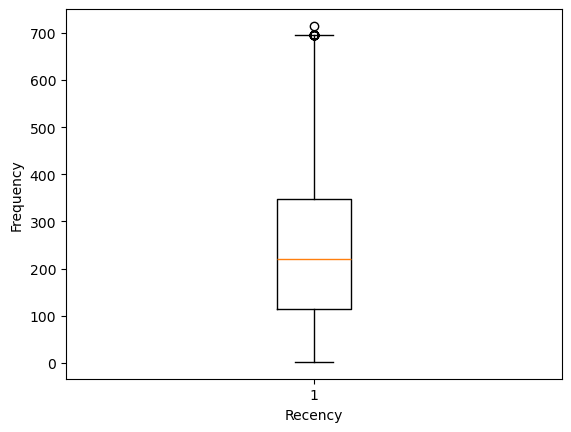

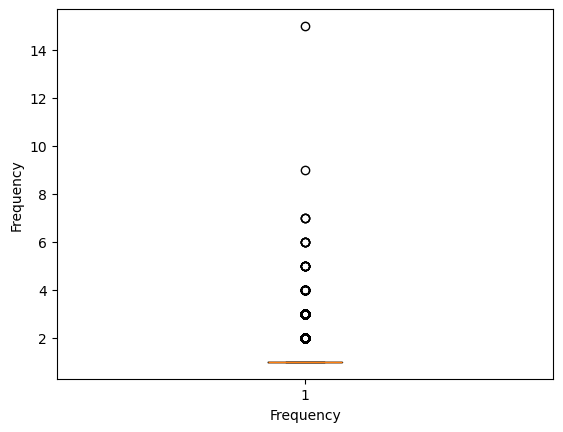

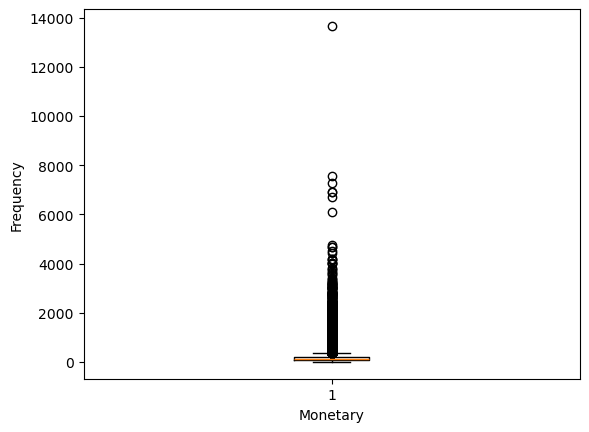

In [37]:
for i in ["Recency", "Frequency", "Monetary"]:
    plt.figure()
    plt.tight_layout()
    plt.gca().set(xlabel= i, ylabel='Frequency')
    plt.boxplot(RFM_df[i])

Let's check outliers that fall with +/- 5% boundaries:

Imagine you have a list of numbers representing, say, the prices of products in a store. When we say "let's check outliers that fall within +/- 5% boundaries," we're looking for unusually high or low prices compared to most of the prices on the list.

Here's how we might do it:

Find Percentiles: We first look at the prices and find two special prices:

The price below which 5% of the prices fall (this is the 5th percentile).
The price below which 95% of the prices fall (this is the 95th percentile).
Set Boundaries:

We then create a range of prices that we consider normal. This range starts at a price slightly below the 5th percentile and ends at a price slightly above the 95th percentile.
Anything outside this range is considered unusual or an outlier.
Check for Outliers: We then look at each price on the list. If a price is outside the normal range we defined, we mark it as an outlier.

So, by saying "let's check outliers that fall within +/- 5% boundaries," we're simply looking for prices that are very different from most of the other prices on the list.

In [38]:
RFM_df[RFM_df["customer_unique_id"] == "005226be8d5b972d0f72b4e8a79f322b"]

,customer_unique_id,Recency,Frequency,Monetary
130,005226be8d5b972d0f72b4e8a79f322b,151,1,1600.51


In [39]:
def num_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_df= df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    return print("Number of outliers in {} column: ".format(col_name), len(outliers_df)), print("Indexes: ", outliers_df.index)

In [40]:
for i in ["Recency", "Frequency", "Monetary"]:
    num_outlier(RFM_df, i)
    print("*"*40)

Number of outliers in Recency column:  0
Indexes:  Index([], dtype='int64')
****************************************
Number of outliers in Frequency column:  2800
Indexes:  Index([  104,   243,   305,   404,   419,   428,   438,   467,   469,   501,
       ...
       92732, 92746, 92802, 92902, 92907, 92975, 93069, 93171, 93189, 93298],
      dtype='int64', length=2800)
****************************************
Number of outliers in Monetary column:  889
Indexes:  Index([  130,   256,   289,   416,   437,   438,   570,   607,   789,   863,
       ...
       92802, 92879, 92920, 92985, 92990, 93065, 93130, 93247, 93330, 93337],
      dtype='int64', length=889)
****************************************


In [41]:
RFM_df.shape

(93342, 4)

Let's remove outliers that fall with +/- 5% boundaries, except Frequency columns:

In [42]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    iqr = q3-q1     
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    index_outliers= df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)].index
    df_in= pd.DataFrame(df_in.drop(index_outliers.to_list(), axis=0, inplace=True))
    print("Outliers in the {} column have been removed".format(col_name))
    return df_in

In [43]:
for i in ["Recency", "Monetary"]:
    remove_outlier(RFM_df, i)
    print("*"*40)

Outliers in the Recency column have been removed
****************************************
Outliers in the Monetary column have been removed
****************************************


In [44]:
RFM_df[RFM_df["customer_unique_id"] == "005226be8d5b972d0f72b4e8a79f322b"]

,customer_unique_id,Recency,Frequency,Monetary


In [45]:
RFM_df.shape

(92453, 4)

In [46]:
RFM_df2= RFM_df.copy()
RFM_df2= RFM_df2.set_index('customer_unique_id')

In [47]:
RFM_df2

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
0000f46a3911fa3c0805444483337064,538,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
0004aac84e0df4da2b147fca70cf8255,289,1,196.89
...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,246,1,167.32
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58
ffff371b4d645b6ecea244b27531430a,569,1,112.46


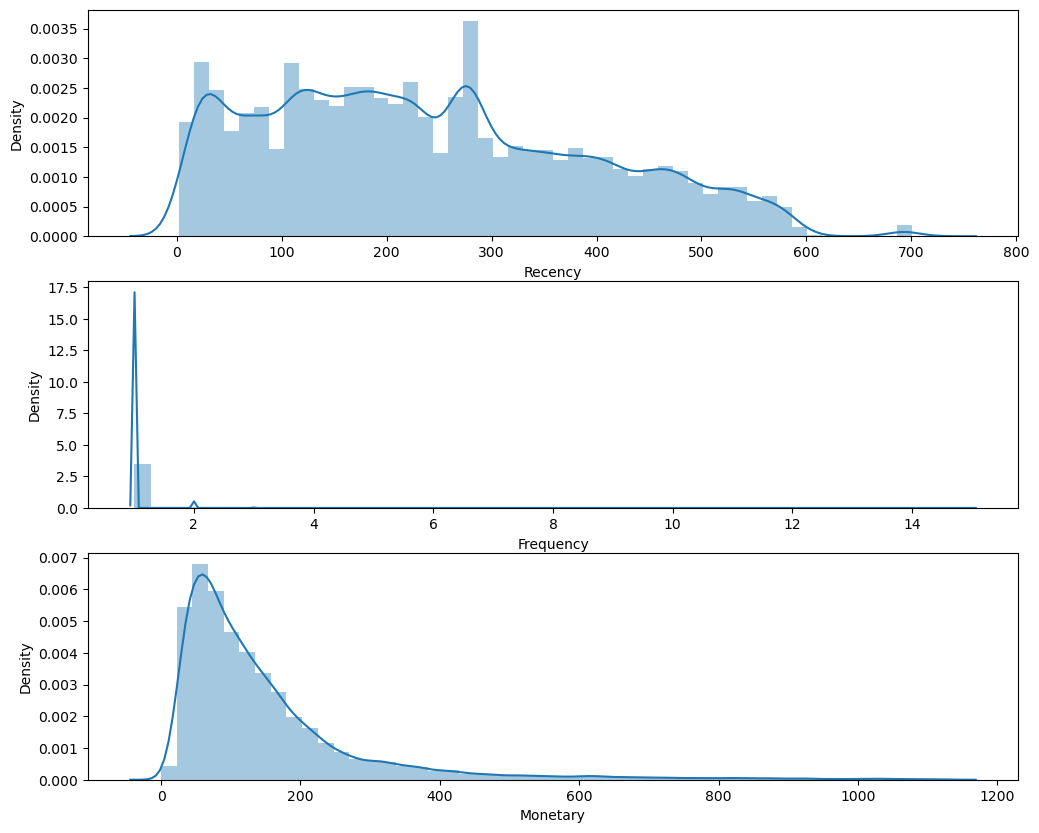

In [48]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1); sns.distplot(RFM_df2['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_df2['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_df2['Monetary'])
plt.show()

# Creating RFM Segments <a name='Creating-RFM-Segments'></a>

[Go to TOC](#top)

This line of code is part of a process to create an RFM (Recency, Frequency, Monetary) score for each customer in a DataFrame called RFM_df2. The RFM score is a way to segment customers based on their transaction behavior. Here's what each part of the code does:



In [49]:
seg_map= {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers', 
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

In [50]:
# Need to add an index to reconnect later
RFM_df2 = RFM_df2.reset_index().reset_index()
RFM_df2_without_index = RFM_df2[["index", "customer_unique_id"]]
RFM_df2.head()

,index,customer_unique_id,Recency,Frequency,Monetary
0,0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
2,2,0000f46a3911fa3c0805444483337064,538,1,86.22
3,3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
4,4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89


In [51]:
# needed to remove customer_unique_id, otherwise quantiles wouldn't work
RFM_df2 = RFM_df2[["index","Recency", "Frequency", "Monetary"]]
RFM_df2.head()

,index,Recency,Frequency,Monetary
0,0,113,1,141.90
1,1,116,1,27.19
2,2,538,1,86.22
3,3,322,1,43.62
4,4,289,1,196.89


In [52]:
#Define quartiles for RFM score:
quantiles = RFM_df2.quantile(q=[0.20,0.4, 0.6, 0.8])
quantiles = quantiles.to_dict()

In [53]:
quantiles = RFM_df2.quantile(q=[0.20,0.4, 0.6, 0.8])
quantiles = quantiles.to_dict()

def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 4
    else:
        return 5
    
RFM_df2['Recency Score'] = RFM_df2['Recency'].apply(RScore, args=('Recency',quantiles))
RFM_df2['Frequency Score'] = RFM_df2['Frequency'].apply(FMScore, args=('Frequency',quantiles))
RFM_df2['Monetary Score'] = RFM_df2['Monetary'].apply(FMScore, args=('Monetary',quantiles))
# Concat RFM quartile values to create RFM Segments
RFM_df2['RFM Score'] = RFM_df2['Recency Score'].astype(str)+ RFM_df2['Frequency Score'].astype(str) + RFM_df2['Monetary Score'].astype(str)
# Calculate RFM_Score
RFM_df2

,index,Recency,Frequency,Monetary,Recency Score,Frequency Score,Monetary Score,RFM Score
0,0,113,1,141.90,4,1,4,414
1,1,116,1,27.19,4,1,1,411
2,2,538,1,86.22,1,1,2,112
3,3,322,1,43.62,2,1,1,211
4,4,289,1,196.89,2,1,4,214
...,...,...,...,...,...,...,...,...
92448,92448,246,1,167.32,3,1,4,314
92449,92449,263,1,84.58,3,1,2,312
92450,92450,569,1,112.46,1,1,3,113
92451,92451,120,1,133.69,4,1,4,414


In [54]:
RFM_df2['Segment'] = RFM_df2['Recency Score'].astype(str) + RFM_df2['Frequency Score'].astype(str) + RFM_df2['Monetary Score'].astype(str)
RFM_df2['Segment'] = RFM_df2['Segment'].replace(seg_map, regex=True)
RFM_df2.head()

,index,Recency,Frequency,Monetary,Recency Score,Frequency Score,Monetary Score,RFM Score,Segment
0,0,113,1,141.90,4,1,4,414,Promising
1,1,116,1,27.19,4,1,1,411,New Customers
2,2,538,1,86.22,1,1,2,112,Lost customers
3,3,322,1,43.62,2,1,1,211,Hibernating customers
4,4,289,1,196.89,2,1,4,214,Cannot Lose Them


In [55]:
RFM_df2.shape

(92453, 9)

In [56]:
# Re match the unique_customer_id
RFM_df2 = RFM_df2.merge(RFM_df2_without_index, on="index")

# moving customer_unique_id to index 0
column_to_move = 'customer_unique_id'
after_which_column = 'index'

# Get the current index of the 'product_id' column
idx = list(RFM_df2.columns).index(after_which_column) + 1

# Insert the 'product_category_name' column after 'product_id'
RFM_df2.insert(idx, column_to_move, RFM_df2.pop(column_to_move))

# Dropping Index Column
RFM_df2 = RFM_df2.drop("index", axis=1)

RFM_df2.head()

,customer_unique_id,Recency,Frequency,Monetary,Recency Score,Frequency Score,Monetary Score,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411,New Customers
2,0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,Lost customers
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,Hibernating customers
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,Cannot Lose Them


In [57]:
RFM_df2.shape

(92453, 9)

In [58]:
RFM_df2["Monetary"].mean()

150.0613338669378

In [59]:
#RFM_df2.to_csv("RFM table 2.csv", index=False)

In [60]:
RFMStats = RFM_df2[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(['mean','median', 'min', 'max', 'count'])
RFMStats

Recency                         Frequency         \
                             mean median  min  max  count      mean median   
Segment                                                                      
About To Sleep         269.063884  269.0  179  383   7091  1.000423    1.0   
At Risk                341.883830  329.0  270  603    637  2.078493    2.0   
Cannot Lose Them       412.293728  410.0  270  696  17523  1.019688    1.0   
Champions               89.815544   89.0    2  178    965  2.175130    2.0   
Hibernating customers  317.699235  314.0  270  383   7451  1.000000    1.0   
Lost customers         474.418340  467.0  384  715   7721  1.001166    1.0   
Loyal                  217.995927  214.0  179  269    491  2.087576    2.0   
New Customers          118.383951  117.0    2  269  18057  1.000000    1.0   
Potential Loyalist     131.864516  134.5    2  268    310  2.016129    2.0   
Promising              134.657342  134.0    2  269  32207  1.000000    1.0   

                                        Monetary                            \
                      min max  count        mean   median     min      max   
Segment                                                                      
About To Sleep          1   2   7091   88.262313   86.150   39.34   131.03   
At Risk                 2   6    637  243.222370  185.090   56.00  1044.13   
Cannot Lose Them        1   4  17523  235.208211  178.260   86.67  1124.96   
Champions               2  15    965  329.199751  265.050  131.08  1122.72   
Hibernating customers   1   1   7451   55.840373   56.780   10.07    86.64   
Lost customers          1   3   7721   55.090600   55.000    0.00    86.64   
Loyal                   2   7    491  311.710428  256.980  131.20  1078.16   
New Customers           1   1  18057   51.113300   48.930    9.59    86.64   
Potential Loyalist      2   3    310   96.764613   99.625   35.94   130.64   
Promising               1   1  32207  208.220812  158.680   86.66  1125.00   

                              
                       count  
Segment                       
About To Sleep          7091  
At Risk                  637  
Cannot Lose Them       17523  
Champions                965  
Hibernating customers   7451  
Lost customers          7721  
Loyal                    491  
New Customers          18057  
Potential Loyalist       310  
Promising              32207

In [61]:
RFMStats['Ratio']= (100*RFMStats['Monetary']["count"]/RFMStats['Monetary']["count"].sum()).round(2)
RFMStats

Recency                         Frequency         \
                             mean median  min  max  count      mean median   
Segment                                                                      
About To Sleep         269.063884  269.0  179  383   7091  1.000423    1.0   
At Risk                341.883830  329.0  270  603    637  2.078493    2.0   
Cannot Lose Them       412.293728  410.0  270  696  17523  1.019688    1.0   
Champions               89.815544   89.0    2  178    965  2.175130    2.0   
Hibernating customers  317.699235  314.0  270  383   7451  1.000000    1.0   
Lost customers         474.418340  467.0  384  715   7721  1.001166    1.0   
Loyal                  217.995927  214.0  179  269    491  2.087576    2.0   
New Customers          118.383951  117.0    2  269  18057  1.000000    1.0   
Potential Loyalist     131.864516  134.5    2  268    310  2.016129    2.0   
Promising              134.657342  134.0    2  269  32207  1.000000    1.0   

                                        Monetary                            \
                      min max  count        mean   median     min      max   
Segment                                                                      
About To Sleep          1   2   7091   88.262313   86.150   39.34   131.03   
At Risk                 2   6    637  243.222370  185.090   56.00  1044.13   
Cannot Lose Them        1   4  17523  235.208211  178.260   86.67  1124.96   
Champions               2  15    965  329.199751  265.050  131.08  1122.72   
Hibernating customers   1   1   7451   55.840373   56.780   10.07    86.64   
Lost customers          1   3   7721   55.090600   55.000    0.00    86.64   
Loyal                   2   7    491  311.710428  256.980  131.20  1078.16   
New Customers           1   1  18057   51.113300   48.930    9.59    86.64   
Potential Loyalist      2   3    310   96.764613   99.625   35.94   130.64   
Promising               1   1  32207  208.220812  158.680   86.66  1125.00   

                              Ratio  
                       count         
Segment                              
About To Sleep          7091   7.67  
At Risk                  637   0.69  
Cannot Lose Them       17523  18.95  
Champions                965   1.04  
Hibernating customers   7451   8.06  
Lost customers          7721   8.35  
Loyal                    491   0.53  
New Customers          18057  19.53  
Potential Loyalist       310   0.34  
Promising              32207  34.84

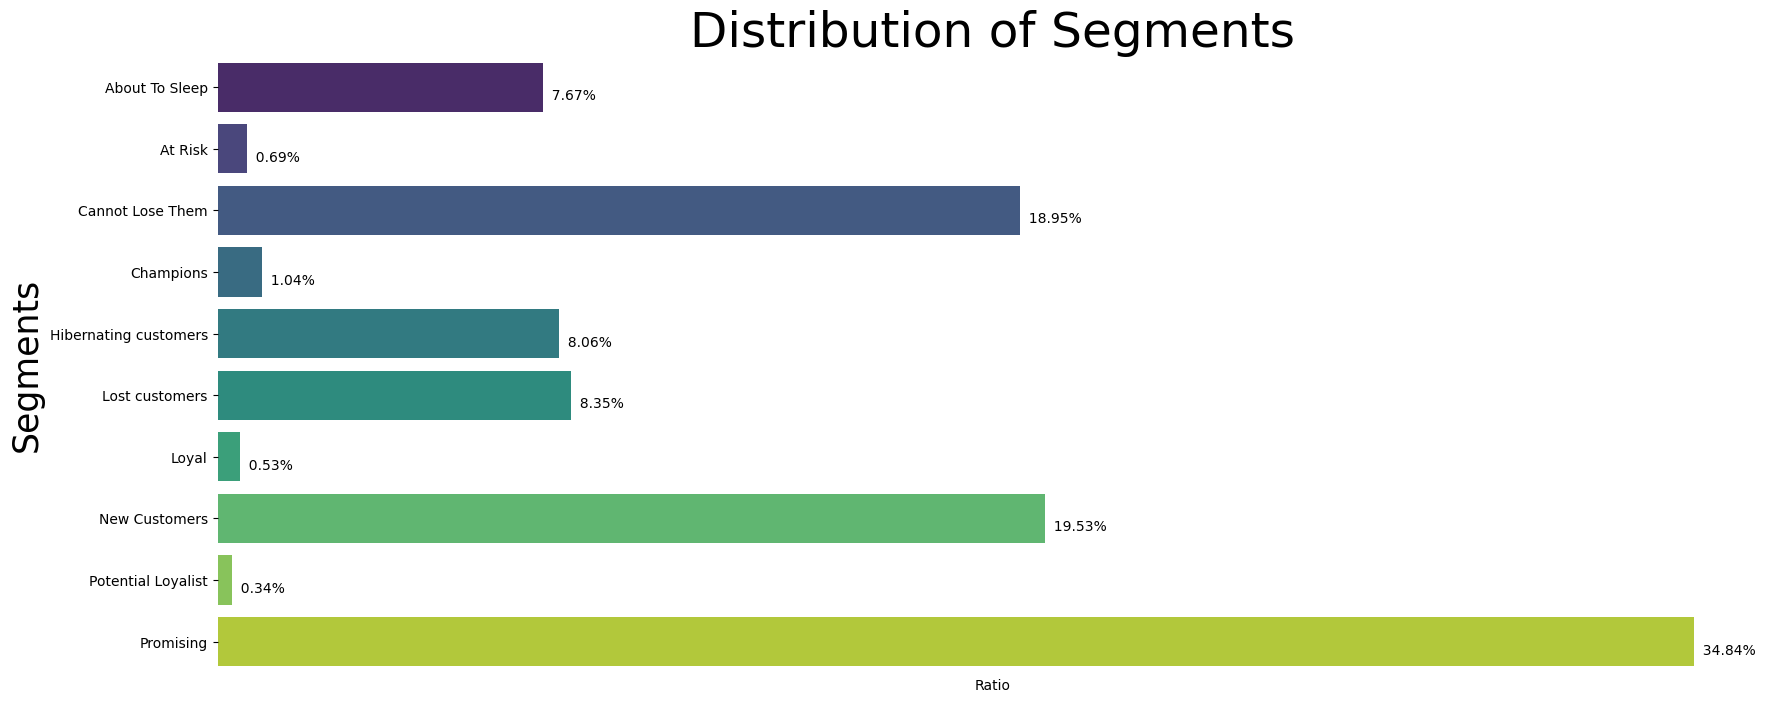

In [62]:
plt.figure(figsize=(20,8))
#plt.rc('font', size=20)
per= sns.barplot(x=RFMStats['Ratio'], y=RFMStats.index, data=RFMStats, palette="viridis")
sns.despine(bottom = True, left = True)
for i, v in enumerate(RFMStats['Ratio']):
    per.text(v, i+.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
per.set_ylabel('Segments', fontsize=25)
per.set(xticks=[])
plt.title('Distribution of Segments', fontsize=35)
plt.show()

</a> <a name='Power-BI-Exports'></a>
# Power BI Exports

**RFM Order Level Table** 

**Table Sources**

| BI              | CSV Name                       | DF Name         | Rows   |
| --------------- | ------------------------------ | --------------- | ------ |
| RFM Table 2     | RFM Table Without Outliers.csv | RFM_df          | 92,453 |
| RFM Order Level | rfm_orders_level.csv           | rfm_order_level | 95,480 |

[Go to TOC](#top)

In [63]:
# Merge this with RFM table 2 
rfm_orders_level = orders.merge(customers[["customer_id", "customer_unique_id"]], on="customer_id", how="left")
rfm_orders_level.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [64]:

# Convert order_purchase_timestamp to datetime
rfm_orders_level['order_purchase_timestamp'] = pd.to_datetime(rfm_orders_level['order_purchase_timestamp'])

# Get the row with the latest order_purchase_timestamp for each customer
latest_orders = rfm_orders_level.loc[rfm_orders_level.groupby('customer_unique_id')['order_purchase_timestamp'].idxmax()]

# Extract customer_id and order_purchase_timestamp
result = latest_orders[['customer_unique_id', 'order_id', 'order_purchase_timestamp']]

# Filter out all the outliers with RFM_df2
#result = result.merge(RFM_df2[["customer_unique_id"]], on="customer_unique_id", how="inner")
result = result.merge(RFM_df2[["customer_unique_id", "Segment"]], on="customer_unique_id", how="inner")

result

,customer_unique_id,order_id,order_purchase_timestamp,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,New Customers
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,Lost customers
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,Hibernating customers
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,Cannot Lose Them
...,...,...,...,...
92448,fffbf87b7a1a6fa8b03f081c5f51a201,64397307c6954ae1ad2ad8e791ad8a31,2017-12-27 22:36:41,Promising
92449,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,About To Sleep
92450,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-07 15:49:16,Cannot Lose Them
92451,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-02 15:17:41,Promising


In [65]:
RFM_df2.shape

(92453, 9)

In [66]:
result["customer_unique_id"].nunique()

92453

In [67]:
result["Segment"].value_counts()

Segment
Promising                32207
New Customers            18057
Cannot Lose Them         17523
Lost customers            7721
Hibernating customers     7451
About To Sleep            7091
Champions                  965
At Risk                    637
Loyal                      491
Potential Loyalist         310
Name: count, dtype: int64

In [68]:
agg_order_payments

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,343.40
99436,fffcd46ef2263f404302a634eb57f7eb,386.53
99437,fffce4705a9662cd70adb13d4a31832d,116.85
99438,fffe18544ffabc95dfada21779c9644f,64.71


In [69]:
# Find All Orders 
rfm_orders_level = rfm_orders_level[["customer_unique_id", "order_id", "order_purchase_timestamp"]]

rfm_orders_level = rfm_orders_level.merge(RFM_df2[["customer_unique_id", "RFM Score"]], on="customer_unique_id", how="inner")

rfm_orders_level = rfm_orders_level.merge(agg_order_payments, on="order_id", how="inner")

rfm_orders_level

,customer_unique_id,order_id,order_purchase_timestamp,RFM Score,payment_value
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,252,38.71
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,514,141.46
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,514,179.12
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,212,72.20
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,311,28.62
...,...,...,...,...,...
95474,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,112,85.08
95475,da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,314,195.00
95476,737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,215,271.01
95477,5097a5312c8b157bb7be58ae360ef43c,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,315,441.16


In [71]:
rfm_orders_level["customer_unique_id"].nunique()

92452

In [72]:
RFM_df2

,customer_unique_id,Recency,Frequency,Monetary,Recency Score,Frequency Score,Monetary Score,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411,New Customers
2,0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,Lost customers
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,Hibernating customers
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,Cannot Lose Them
...,...,...,...,...,...,...,...,...,...
92448,fffbf87b7a1a6fa8b03f081c5f51a201,246,1,167.32,3,1,4,314,Promising
92449,fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,3,1,2,312,About To Sleep
92450,ffff371b4d645b6ecea244b27531430a,569,1,112.46,1,1,3,113,Cannot Lose Them
92451,ffff5962728ec6157033ef9805bacc48,120,1,133.69,4,1,4,414,Promising


In [ ]:
# Export
# result.to_csv("latest_orders_by_cust_uni_id.csv", index=False)
# rfm_orders_level.to_csv("rfm_orders_level.csv", index=False)